In [35]:
#imports
import pandas as pd
import json
import matplotlib.pyplot as plt
from datetime import datetime

In [36]:
# Load sleep data
sleep_data = pd.read_csv('sleep-data.csv', delimiter=';')

# Convert datetime columns to proper datetime objects
sleep_data['Went to bed'] = pd.to_datetime(sleep_data['Went to bed'])
sleep_data['Woke up'] = pd.to_datetime(sleep_data['Woke up'])

# Load watch history JSON
with open('watch-history.json', 'r', encoding='utf-8') as f:
    watch_history = json.load(f)

# Parse watch history into a DataFrame
watch_history_data = []
for entry in watch_history:
    try:
        watch_time = datetime.strptime(entry['time'], '%Y-%m-%dT%H:%M:%S.%fZ')
    except ValueError:
        try:
            watch_time = datetime.strptime(entry['time'], '%Y-%m-%dT%H:%M:%SZ')
        except ValueError:
            print(f"Unrecognized time format: {entry['time']}")
            continue
    title = entry['title']
    platform = entry['header']
    watch_history_data.append({'Time': watch_time, 'Title': title, 'Platform': platform})

watch_df = pd.DataFrame(watch_history_data)

# Merge datasets
# Find the closest watch time before sleep
merged_data = []
for index, row in sleep_data.iterrows():
    sleep_start = row['Went to bed']
    relevant_watches = watch_df[watch_df['Time'] < sleep_start]
    if not relevant_watches.empty:
        last_watch = relevant_watches.iloc[-1]
        merged_data.append({
            'Sleep Start': sleep_start,
            'Sleep Quality': row['Sleep Quality'],
            'Time in bed (seconds)': row['Time in bed (seconds)'],
            'Time asleep (seconds)': row['Time asleep (seconds)'],
            'Last Watch Time': last_watch['Time'],
            'Last Watch Title': last_watch['Title'],
            'Platform': last_watch['Platform']
        })

merged_df = pd.DataFrame(merged_data)

# Convert Sleep Quality to numeric for analysis
merged_df['Sleep Quality'] = merged_df['Sleep Quality'].str.rstrip('%').astype(float)

# Visualization: Scatter plot of watch time vs. sleep quality
plt.figure(figsize=(10, 6))
plt.scatter(merged_df['Last Watch Time'], merged_df['Sleep Quality'], alpha=0.7)
plt.xlabel('Last Watch Time')
plt.ylabel('Sleep Quality (%)')
plt.title('Effect of Watch Time on Sleep Quality')
plt.xticks(rotation=45)
plt.grid()
plt.show()

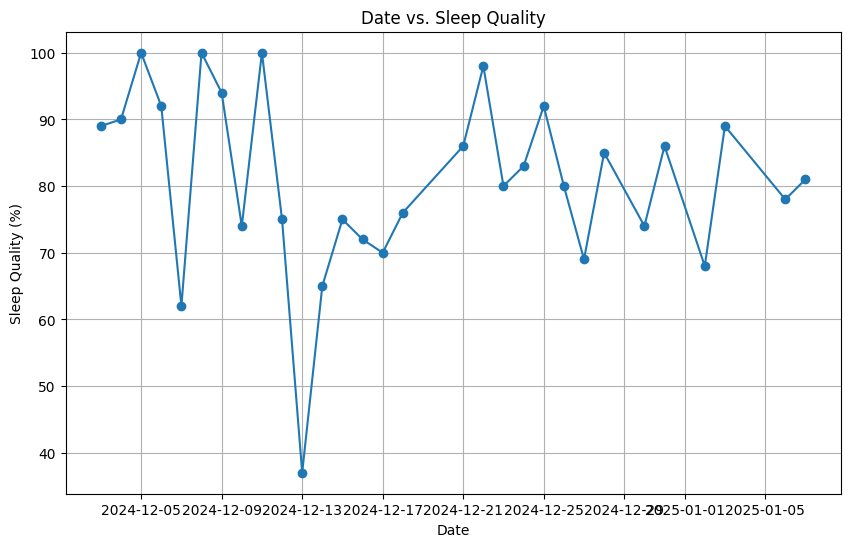

<Figure size 1200x800 with 0 Axes>

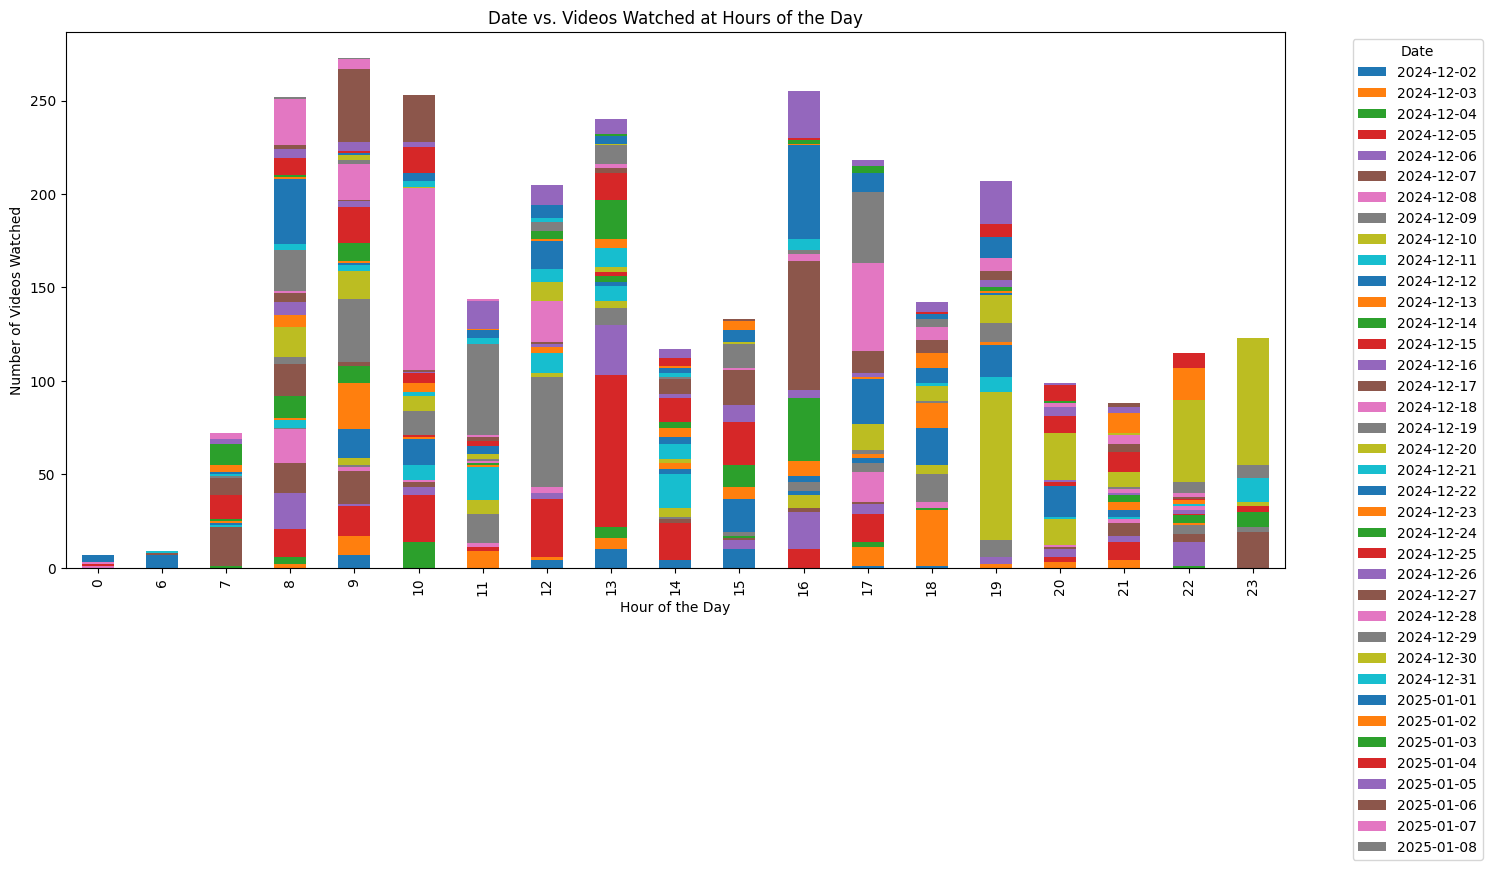

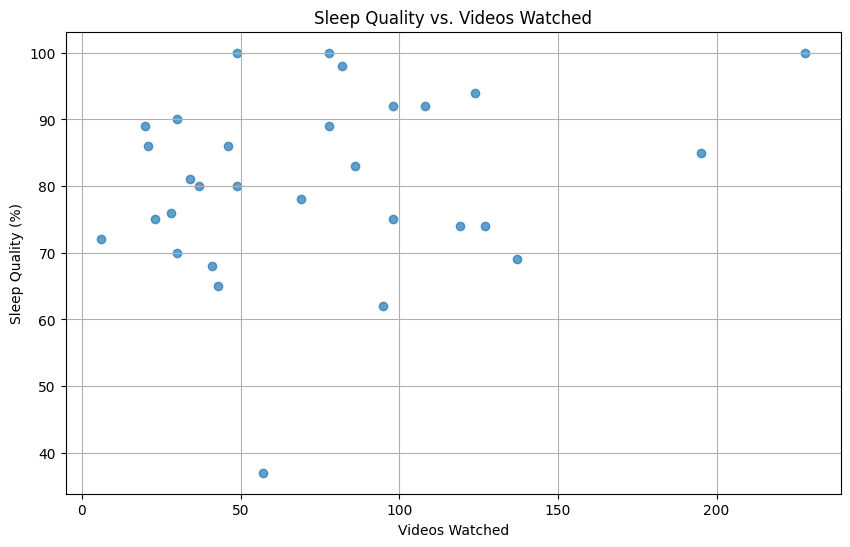

In [37]:
#import pandas as pd
#import json
#import matplotlib.pyplot as plt
#from datetime import datetime

# Load sleep data
#sleep_data = pd.read_csv('/mnt/data/My complete sleep data.csv', delimiter=';')
sleep_data = pd.read_csv('sleep-data.csv', delimiter=';')
# Convert datetime columns to proper datetime objects
sleep_data['Went to bed'] = pd.to_datetime(sleep_data['Went to bed'])
sleep_data['Woke up'] = pd.to_datetime(sleep_data['Woke up'])

# Ensure sleep quality is numeric
sleep_data['Sleep Quality'] = sleep_data['Sleep Quality'].str.replace('%', '').astype(float)

# Extract date from 'Went to bed'
sleep_data['Date'] = sleep_data['Went to bed'].dt.date

# Load watch history JSON
#with open('/mnt/data/watch-history 2.json', 'r', encoding='utf-8') as f:
    #watch_history = json.load(f)
with open('watch-history.json', 'r', encoding='utf-8') as f:
    watch_history = json.load(f)
# Convert watch history into a DataFrame and process timestamps
watch_data = pd.DataFrame(watch_history)

# Use format='mixed' to handle mixed datetime formats
watch_data['time'] = pd.to_datetime(watch_data['time'], format='mixed', errors='coerce')

# Drop rows where time conversion failed
watch_data = watch_data.dropna(subset=['time'])

# Extract date and hour
watch_data['date'] = watch_data['time'].dt.date
watch_data['hour'] = watch_data['time'].dt.hour

# 1. Plot Date vs. Sleep Quality
plt.figure(figsize=(10, 6))
plt.plot(sleep_data['Date'], sleep_data['Sleep Quality'], marker='o', linestyle='-')
plt.title('Date vs. Sleep Quality')
plt.xlabel('Date')
plt.ylabel('Sleep Quality (%)')
plt.grid()
plt.show()

# 2. Plot Date vs. Videos Watched at Hours of the Day
watch_count_by_hour = watch_data.groupby(['date', 'hour']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 8))
watch_count_by_hour.T.plot(kind='bar', stacked=True, figsize=(15, 8))
plt.title('Date vs. Videos Watched at Hours of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Videos Watched')
plt.legend(title='Date', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 3. Plot Sleep Quality vs. Videos Watched at Hours of the Day
# Aggregate videos watched by date
videos_by_date = watch_data.groupby('date').size().rename('Videos Watched')

# Merge with sleep data
merged_data = sleep_data.merge(videos_by_date, how='left', left_on='Date', right_on='date')
merged_data['Videos Watched'] = merged_data['Videos Watched'].fillna(0)

plt.figure(figsize=(10, 6))
plt.scatter(merged_data['Videos Watched'], merged_data['Sleep Quality'], alpha=0.7)
plt.title('Sleep Quality vs. Videos Watched')
plt.xlabel('Videos Watched')
plt.ylabel('Sleep Quality (%)')
plt.grid()
plt.show()

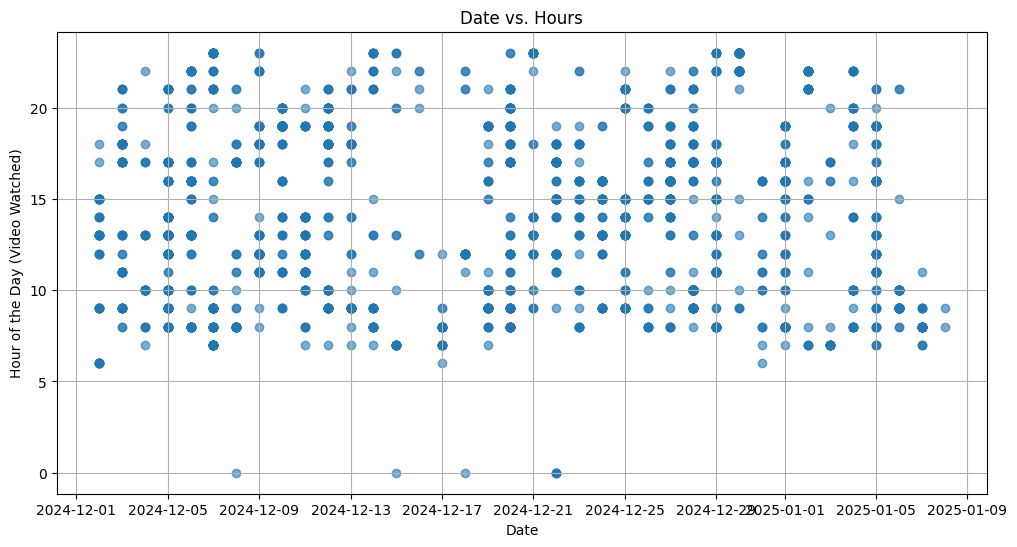

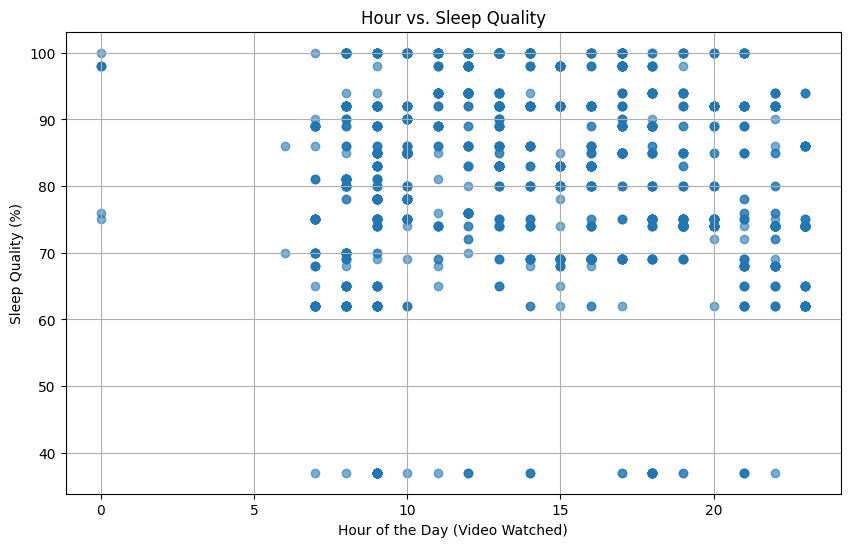

In [38]:
# Additional Plot 1: Date vs. Hours (Dot Plot)
plt.figure(figsize=(12, 6))
plt.scatter(watch_data['date'], watch_data['hour'], alpha=0.6)
plt.title('Date vs. Hours')
plt.xlabel('Date')
plt.ylabel('Hour of the Day (Video Watched)')
plt.grid(True)
plt.show()

# Additional Plot 2: Hour vs. Sleep Quality
# Merge hourly video watching data with sleep data
hourly_quality_data = sleep_data.merge(watch_data, how='inner', left_on='Date', right_on='date')

plt.figure(figsize=(10, 6))
plt.scatter(hourly_quality_data['hour'], hourly_quality_data['Sleep Quality'], alpha=0.6)
plt.title('Hour vs. Sleep Quality')
plt.xlabel('Hour of the Day (Video Watched)')
plt.ylabel('Sleep Quality (%)')
plt.grid(True)
plt.show()